In [1]:
cd ../pipelines

/Users/mathieuchevalley/Documents/Study/ETHZ/Fall Semester 2020/Data Science lab/data_sc_lab/task_01/pipelines


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipynb.fs.full.tool_functions import *
from yellowbrick.regressor import AlphaSelection

Using TensorFlow backend.


In [3]:
df_beha = pd.read_csv('../../../data/Behavioral/AllData.csv')#, nrows=1000)

df_psd_cluster = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Cluster.csv") #, nrows=1000)
df_psd_channel = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Channel.csv") #, nrows=5)
df_spectro_cluster = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Cluster.csv") #, nrows=1000)
df_spectro_channel = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Channel.csv") #, nrows=5)

df_microstate = pd.read_csv("../../../data/EEG/RestingEEG_Microstates.csv") #, nrows=5)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (66,68,80,81,82,83,84,95,96,97,98,99,110,111,112,113,114,125,126,127,128,129,140,141,142,144,155,156,157,159,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103

In [4]:
# Extract relevant info from the Behavioral data 
y_labels = df_beha[["Patient_ID", "Age", "DX_01_Cat"]]
y_labels_healthy = y_labels[y_labels["DX_01_Cat"].str.contains("No Diagnosis Given") == True]

y_labels = y_labels[["Patient_ID", "Age"]]
y_labels_healthy = y_labels_healthy[["Patient_ID", "Age"]]
y_labels_healthy

,Patient_ID,Age
9,NDARCF462HNM,14.216632
11,NDARFC233RND,9.153661
22,NDARDT800YVF,17.510381
25,NDARZT011LBZ,7.760209
26,NDARKV482FU9,10.977298
...,...,...
2088,NDARAV069HGT,13.896189
2089,NDARZC497BFU,17.419917
2090,NDARDZ737LG9,13.031143
2094,NDARRT283RHB,10.712069


In [5]:
df_psd_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_spectro_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_microstate.rename(columns={'id': 'Patient_ID'}, inplace=True)
print("Original lengths: " + str(len(df_psd_cluster)) + "(psd), " + \
     str(len(df_spectro_cluster)) + "(spectro), " + str(len(df_microstate)) + "(micro)")

# Aggregate with label
df_label_psd_cluster = pd.merge(y_labels_healthy, df_psd_cluster, on='Patient_ID')
df_label_spectro_cluster = pd.merge(y_labels_healthy, df_spectro_cluster, on='Patient_ID')
df_label_microstate = pd.merge(y_labels_healthy, df_microstate, on='Patient_ID')
print("Only healthy people, resulting lengths: " + str(len(df_label_psd_cluster)) + "(psd), " + \
     str(len(df_label_spectro_cluster)) + "(spectro), " + str(len(df_label_microstate)) + "(micro)")

# Drop NaN values
df_label_psd_cluster = fill_with_median(df_label_psd_cluster)
df_label_spectro_cluster = fill_with_median(df_label_spectro_cluster)
df_label_microstate = fill_with_median(df_label_microstate)
print("Replace NaN by median, resulting lenghts: " + str(len(df_label_psd_cluster)) + "(psd), " + \
     str(len(df_label_spectro_cluster)) + "(spectro), " + str(len(df_label_microstate)) + "(micro)")

Original lengths: 1485(psd), 1485(spectro), 1108(micro)
Only healthy people, resulting lengths: 174(psd), 174(spectro), 128(micro)
Replace NaN by median, resulting lenghts: 174(psd), 174(spectro), 128(micro)


In [6]:
test_ratio = 0.2

In [79]:
# Define Train and Test data 
print()
print("---- Split into Train and Test data ----")
print()

from sklearn.model_selection import train_test_split
x_train , x_test, y_train , y_test = \
train_test_split(df_label_spectro_cluster.drop(['Age', 'Patient_ID'], axis=1), df_label_spectro_cluster[['Age']], test_size=0.2, random_state = 10)




---- Split into Train and Test data ----



In [80]:
#x_train = X_train_spe.loc[:,X_train_spe.columns != 'Patient_ID']
#y_train = y_train_spe.loc[:,y_train_spe.columns != 'Patient_ID']
#x_test = X_test_spe.loc[:,X_train_spe.columns != 'Patient_ID']
#y_test = y_test_spe.loc[:,y_train_spe.columns != 'Patient_ID']

In [81]:
forest = IsolationForest()
forest.fit(x_train)

# Outlier indices for training
outliers_training = forest.predict(x_train)
outliers_training_indices = np.argwhere(outliers_training == 1).flatten()

# Drop signal outliers in training data
x_train = x_train[outliers_training == 1]
y_train = y_train[outliers_training == 1]
#x_train, y_train = drop_outliers_samples_isolation_forest(x_train, y_train)
print(outliers_training_indices)
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


[  0   1   2   3   4   6   7   8   9  10  12  13  14  15  16  17  20  22
  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  47  49  50  51  52  53  55  56  57  58  59  60  61  62
  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 137 138]
(35, 300)
(35, 1)
(125, 300)
(125, 1)


In [82]:
# Feature Scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)

print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(35, 300)
(35, 1)
(125, 300)
(125, 1)


In [83]:
from sklearn import svm
import sklearn

In [84]:
clf = svm.SVR()
clf.fit(x_train, y_train)
sklearn.metrics.mean_squared_error(y_test, clf.predict(x_test))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6.077723251626924

In [85]:
from sklearn.model_selection import GridSearchCV

In [103]:
svr= svm.SVR()
parameters = {'kernel' : ( 'rbf' , 'poly', 'linear', 'sigmoid' ), 'C':[0.1, 1,10,100], 'gamma':['auto', 10e-2, 10e-1, 1, 2]}
clf = GridSearchCV(svr, parameters ,cv =5, scoring='neg_mean_squared_error')
clf.fit(x_train , y_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['auto', 0.1, 1.0, 1, 2],
                         'kernel': ('rbf', 'poly', 'linear', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [104]:
print(clf.best_estimator_)
best_param = clf.best_params_
print("Best score = " , clf.best_score_)
print("Best param = " , best_param)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best score =  -7.249548350902781
Best param =  {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}


In [105]:
svr_final = svm.SVR(kernel = best_param['kernel'] , C = best_param['C'])
svr_final.fit(x_train , y_train)
test_mse_svm = sklearn.metrics.mean_squared_error(y_test , svr_final.predict(x_test))
print('TEST MSE = ', test_mse_svm)

TEST MSE =  5.44883013156668


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


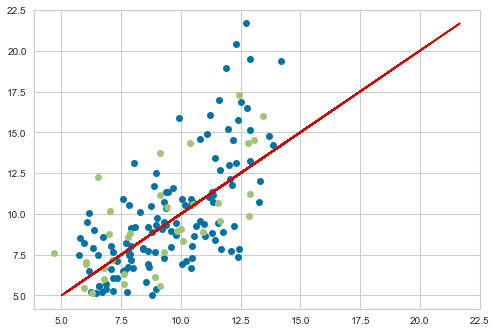

In [106]:
plt.plot(svr_final.predict(x_train) , y_train , 'o')
plt.plot(svr_final.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)

In [90]:
svr_cross = fit_svr_with_grid_search(x_train, y_train)

Best parameters for SVR: {'C': 1000000.0, 'gamma': 0.1, 'kernel': 'poly'}


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [91]:
sklearn.metrics.mean_squared_error(y_test , svr_cross.predict(x_test))

39.21437922100837

In [92]:
def fit_xgboost_with_grid_search(X_train, y_train):

    # Create gradient boosting object
    xgbr = XGBRegressor(verbosity=1, max_depth=10, reg_lambda=1) 
    
    # Grid search 
    parameters = {'max_depth':[1,2,4], 'reg_lambda':[4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_child_weight':[6, 8, 12,16, 20, 25, 30]}
    clf = GridSearchCV(xgbr, parameters, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
    clf.fit(X_train, y_train)
    
    print("Best parameters for XGBoost: " + str(clf.best_params_))
            
    return clf

In [93]:
xb_boost = fit_xgboost_with_grid_search(x_train, y_train)

Best parameters for XGBoost: {'max_depth': 4, 'min_child_weight': 16, 'reg_lambda': 18}


In [94]:
xb_boost.best_score_

-5.844308752037724

In [107]:
xgbr = XGBRegressor(verbosity=1, max_depth=4, min_child_weight= 16, reg_lambda=18) 
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=16, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=18, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [108]:
test_mse_xg = sklearn.metrics.mean_squared_error(y_test , xgbr.predict(x_test))
print('TEST MSE = ', test_mse_xg)

TEST MSE =  4.6006756094721855


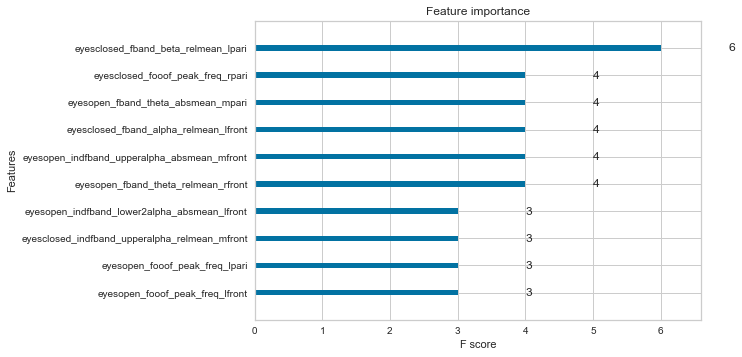

In [97]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgbr, max_num_features=10)
pyplot.show()

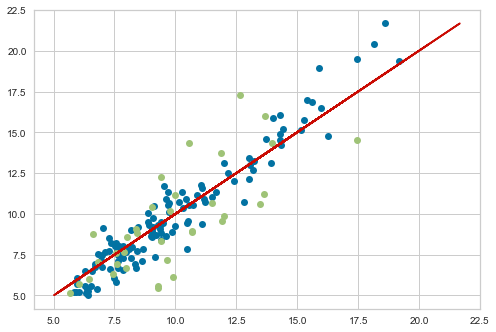

In [98]:
plt.plot(xgbr.predict(x_train) , y_train , 'o')
plt.plot(xgbr.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)

In [99]:
gpr = GaussianProcessRegressor(n_restarts_optimizer=5)
    
# Grid search
parameters = {
    'kernel': [RationalQuadratic(), RBF(), Matern(length_scale=1, nu=1.5),  DotProduct()], 'alpha': [1e-10, 1e-5, 1e-3, 1e-1, 1., 1.5, 2.]}
clf = GridSearchCV(gpr, parameters, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
clf.fit(x_train, y_train)
clf.best_params_

{'alpha': 1.0, 'kernel': Matern(length_scale=1, nu=1.5)}

In [100]:
clf.best_score_

-7.631265036391295

In [101]:
sklearn.metrics.mean_squared_error(y_test , clf.predict(x_test))

6.272102616789

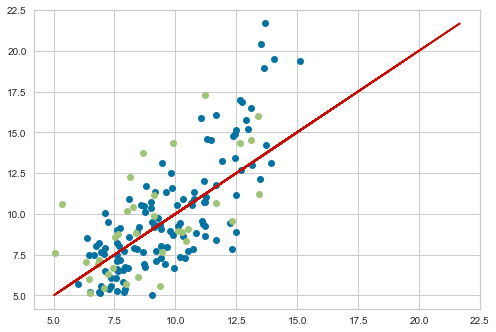

In [102]:
plt.plot(clf.predict(x_train) , y_train , 'o')
plt.plot(clf.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)

In [30]:
rdf = fit_random_forest_with_grid_search(x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters for Random Forest: {'max_depth': 30, 'max_leaf_nodes': 250, 'min_samples_split': 2, 'n_estimators': 1000}


In [31]:
rdf.best_params_

{'max_depth': 30,
 'max_leaf_nodes': 250,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [32]:
rdf.best_score_

-5.946657940560745

In [33]:
sklearn.metrics.mean_squared_error(y_test , rdf.predict(x_test))

4.745646592888949

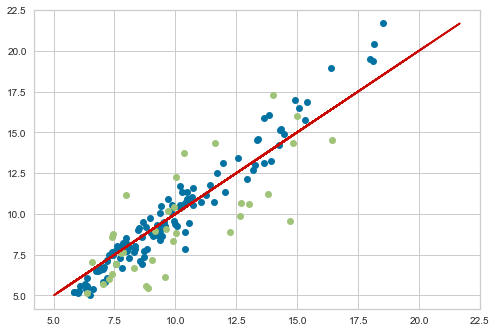

In [34]:
plt.plot(rdf.predict(x_train) , y_train , 'o')
plt.plot(rdf.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)